## Ensemble Models

*Prepared by:*  
**Jude Michael Teves**  
Faculty, Software Technology Department  
College of Computer Studies - De La Salle University

## Preliminaries

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import seaborn as sns

sns.set_style('darkgrid')

sns.set_palette('Set2')
sns.color_palette('Set2')

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

### Prepare Dataset

In [8]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/Cyntwikip/data-repository/main/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
from sklearn.impute import SimpleImputer

X = df.drop(['Survived','PassengerId','Name','Ticket','Cabin'], axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cols = X_train.columns
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train)
X_train = pd.DataFrame(imp_mean.transform(X_train), columns=cols)
X_test = pd.DataFrame(imp_mean.transform(X_test), columns=cols)

print(f"Train Set Size | Input: {X_train.shape}, Output: {y_train.shape}")
print(f"Test Set Size | Input: {X_test.shape}, Output: {y_test.shape}")

Train Set Size | Input: (712, 8), Output: (712,)
Test Set Size | Input: (179, 8), Output: (179,)


## Random Forest

Random Forest is a combination of multiple decision trees built from different samples drawn with replacement (bootstrapping). This is a form of Boostrap Aggregating, also known as `Bagging`.

> In ensemble algorithms, bagging methods form a class of algorithms which build several instances of a black-box estimator on random subsets of the original training set and then aggregate their individual predictions to form a final prediction. These methods are used as a way to reduce the variance of a base estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it. In many cases, bagging methods constitute a very simple way to improve with respect to a single model, without making it necessary to adapt the underlying base algorithm. As they provide a way to reduce overfitting, bagging methods work best with strong and complex models (e.g., fully developed decision trees), in contrast with boosting methods which usually work best with weak models (e.g., shallow decision trees).

Individual decision trees usually have high variance and are prone to overfitting. The added randomness in forests due to boostrapping helps produce decision trees with somewhat independent prediction errors. By averaging these predictions, some errors cancel out. Random forests achieve lower variance by combining diverse trees, though this sometimes slightly increases bias. In practice, the reduction in variance is often substantial, resulting in an overall improved model.

In [60]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=5, max_depth=3, random_state=42)
model.fit(X_train, y_train)
print(f"Score: {model.score(X_test, y_test):.2%}")

Score: 78.77%


### Inspecting the Decision Tree sub-models

We can see that we have 5 `Decision Trees` in our `Random Forest` model. Let's inspect some of those trees.

In [61]:
model.estimators_

[DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                        random_state=1608637542),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                        random_state=1273642419),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                        random_state=1935803228),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=787846414),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=996406378)]

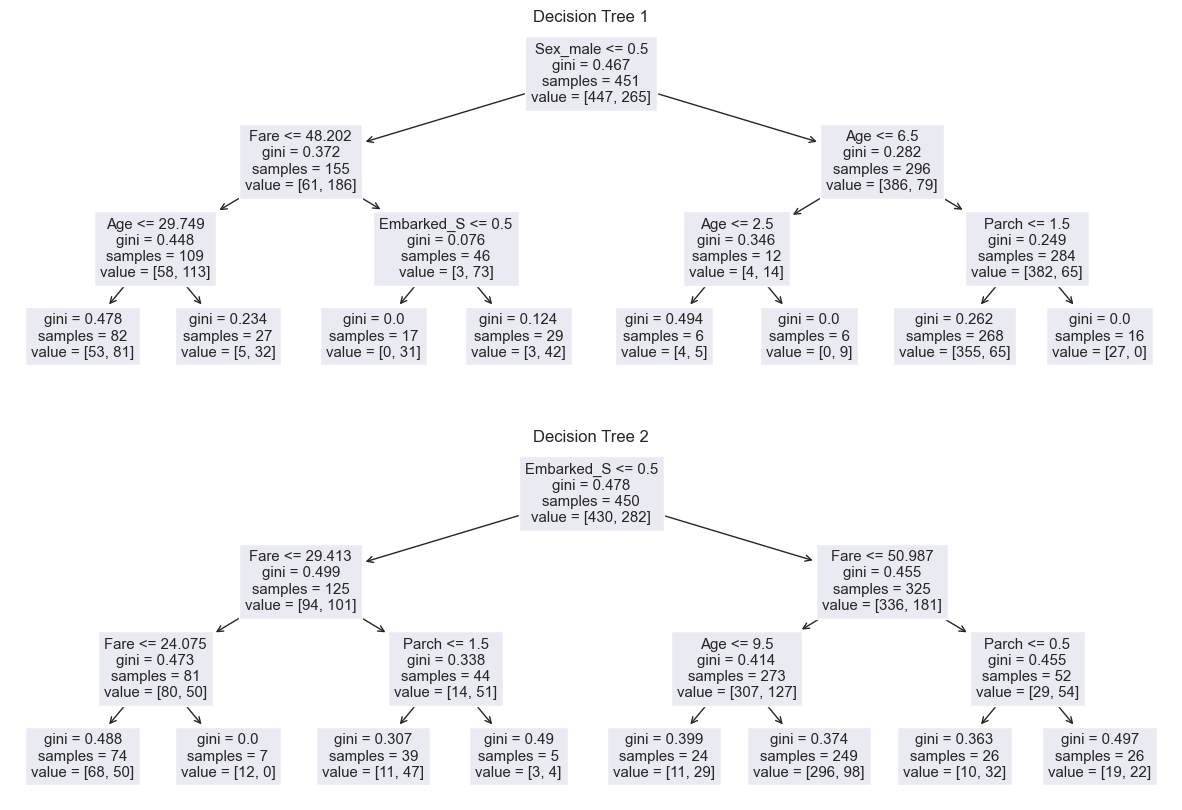

In [63]:
from sklearn import tree

fig, ax = plt.subplots(2,1, figsize=(15,10))

sub_model1 = model.estimators_[0]
tree.plot_tree(sub_model1, feature_names=list(cols), ax=ax[0])
ax[0].set_title('Decision Tree 1')

sub_model2 = model.estimators_[1]
tree.plot_tree(sub_model2, feature_names=list(cols), ax=ax[1])
ax[1].set_title('Decision Tree 2')

plt.show()

As can be seen above, the first 2 `Decision Trees` are different since they are trained on different samples of our train dataset.

### Wisdom of the Crowd

We can verfiy that the output of the `Random Forest` model is the average of the `Decision Tree` models. 

In [91]:
array = []
for i in range(5):
    sub_model = model.estimators_[i]
    pred = sub_model.predict_proba(X_test.loc[[0],:])[0]
    array.append(pred)

sub_model_probs = pd.DataFrame(array,columns=[0,1]) 
sub_model_probs

/Users/judemichaelteves/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/judemichaelteves/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/judemichaelteves/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/judemichaelteves/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/judemichaelteves/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


,0,1
0,0.845238,0.154762
1,0.576271,0.423729
2,0.786667,0.213333
3,0.850000,0.150000
4,0.754545,0.245455


In [96]:
sub_model_probs.mean(axis=0)

0    0.762544
1    0.237456
dtype: float64

In [92]:
model.predict_proba(X_test.loc[[0],:])[0]

array([0.76254428, 0.23745572])

In [95]:
sub_model_probs.mean(axis=0) == model.predict_proba(X_test.loc[[0],:])[0]

0    True
1    True
dtype: bool

## AdaBoost

AdaBoost is a very popular `Boosting` algorithm. It works by fitting a series of simple models—usually very shallow decision trees—each one focusing on correcting the errors of the previous ones. After each model is trained, the data is reweighted: samples that were misclassified are given more weight, while correctly classified ones are given less. This way, each new model zeroes in on the harder cases. Finally, the predictions from all models are combined using a weighted vote, creating a stronger, more accurate final prediction.

In [183]:
from sklearn.ensemble import AdaBoostClassifier

n_estimators = 10
model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=0.5, random_state=42)
model.fit(X_train, y_train)
print(f"Score: {model.score(X_test, y_test):.2%}")

Score: 79.89%


### Inspecting the submodels

You can see that the submodels have different rules.

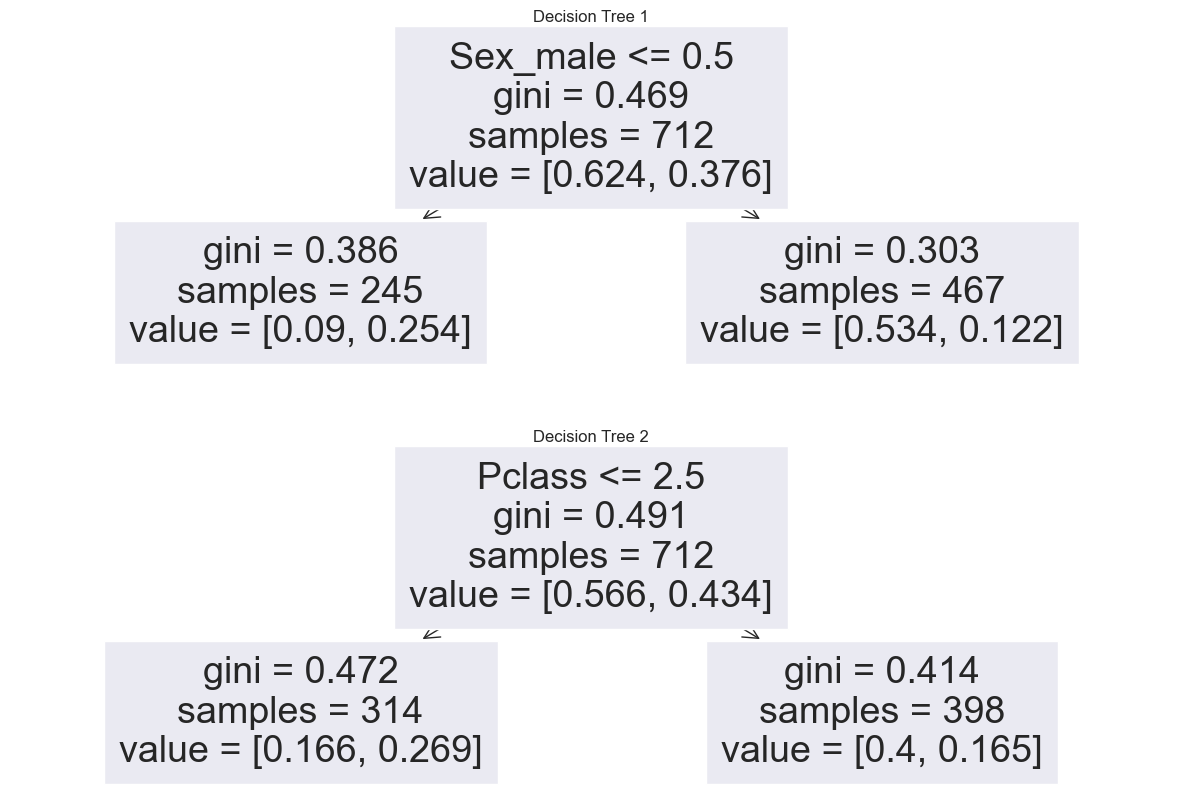

In [184]:
fig, ax = plt.subplots(2,1, figsize=(15,10))

sub_model1 = model.estimators_[0]
tree.plot_tree(sub_model1, feature_names=list(cols), ax=ax[0])
ax[0].set_title('Decision Tree 1')

sub_model2 = model.estimators_[1]
tree.plot_tree(sub_model2, feature_names=list(cols), ax=ax[1])
ax[1].set_title('Decision Tree 2')

plt.show()

In [185]:
model.estimator_weights_
# model.estimator_errors_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

And they have different scores. Interestingly enough, the initial decision tree model is strong enough already.

In [186]:
for i in range(n_estimators):
    sub_model = model.estimators_[i]
    print(f"Model {i} Score:", sub_model.score(X_test, y_test))

Model 0 Score: 0.7821229050279329
Model 1 Score: 0.6759776536312849
Model 2 Score: 0.7821229050279329
Model 3 Score: 0.6703910614525139
Model 4 Score: 0.6089385474860335
Model 5 Score: 0.441340782122905
Model 6 Score: 0.7821229050279329
Model 7 Score: 0.5921787709497207
Model 8 Score: 0.7039106145251397
Model 9 Score: 0.41899441340782123


/Users/judemichaelteves/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/judemichaelteves/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/judemichaelteves/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/judemichaelteves/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/judemichaelteves/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/judemichaelteves/a

### Wisdom of the Crowd

Let's manually aggregate the predictions of the submodels.

In [195]:
pred_array = []

for i in range(n_estimators):
    sub_model = model.estimators_[i]
    pred_prob = sub_model.predict_proba(X_test)[:,1]
    pred_prob = pred_prob*model.estimator_weights_[i]
    pred_array += [pred_prob]

pred_array = np.array(pred_array)
# pred_array.shape
mean_pred = pred_array.mean(axis=0)
class_pred = (mean_pred >= 0.5).astype(int)

class_pred

/Users/judemichaelteves/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/judemichaelteves/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/judemichaelteves/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/judemichaelteves/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/judemichaelteves/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/judemichaelteves/a

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1])

Sanity Check! We got the same score.

In [197]:
score = sum(class_pred == y_test)/len(class_pred)
print(f"Score: {score:.2%}")

Score: 79.89%


## XGBoost

In [ ]:
## TODO

## End
<sup>made by **Jude Michael Teves**</sup> <br>
<sup>for comments, corrections, suggestions, please email:</sup><sup> <href>judemichaelteves@gmail.com</href> or <href>jude.teves@dlsu.edu.ph</href></sup><br>
